<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Carlos_Ancasi/Aula_6_Exerc%C3%ADcio_Carlos_Ancasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [138]:
nome = 'Carlos Leonardo Ancasi Hinostroza'

print(f'Meu nome é {nome}')

Meu nome é Carlos Leonardo Ancasi Hinostroza


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [139]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [140]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('GPU available:', device)

GPU available: cuda


## Fixando as seeds

In [141]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [142]:
batch_size = 50

## Download do CIFAR-10

In [143]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [144]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [145]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

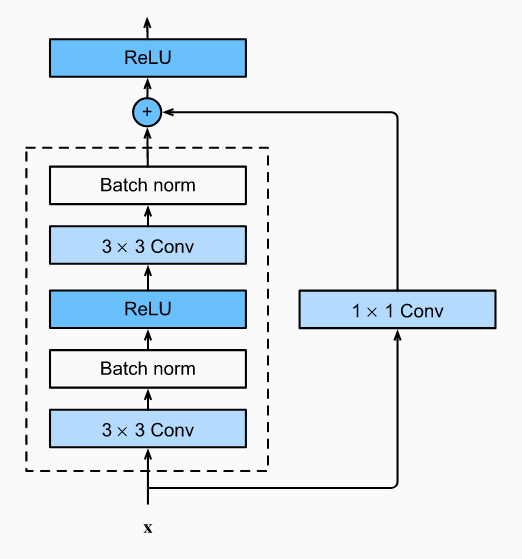

In [146]:
from collections import OrderedDict
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [147]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [153]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.conv_layer = nn.Sequential(OrderedDict([
            ('bl1', MyBasicBlock(inplanes=3, planes = 32, stride=1 )),
            ('bl2', MyBasicBlock(inplanes=32, planes = 64, stride=2 )),
            # ('avg_pool1', nn.AvgPool2d(2)),
            # ('bl3', MyBasicBlock(inplanes=32, planes = 64, stride=2 )),
            # ('bl4', MyBasicBlock(inplanes=64, planes = 64, stride=1 )),
            # ('avg_pool2', nn.AvgPool2d(2)),
            ('bl5', MyBasicBlock(inplanes=64, planes = 128, stride=2 )),
            # ('bl6', MyBasicBlock(inplanes=128, planes = 128, stride=1 )),
            ('avg_pool3', nn.AvgPool2d(2))
        ]))
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(4*4*128, 128)),
            ('relu1', nn.ReLU()),
            # ('drop',  nn.Dropout(p=0.5)),
            ('dense2', nn.Linear(128, 10)),
        ]))

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.conv_layer(x)
        out = out.view(-1,4*4*128)
        out = self.dense_layer(out)
        return out

## Treinamento

### Definição dos hiperparâmetros

In [149]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [150]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU available:', device)

GPU available: cuda


In [151]:
def evaluation(model, loader):
    total = None
    ciertos = None
    mean_accuracy = 0.0
    # Escreva seu código aqui.
    with torch.no_grad():
        total = 0.0
        ciertos = 0.0
        for x_loader, y_loader in loader:
            x_loader = x_loader.to(device)
            y_loader = y_loader.to(device)

            y_model = model(x_loader)

            clase = torch.softmax(y_model, dim=1)
            clase = clase.argmax(dim=1)
            
            ciertos += (clase == y_loader).sum().item()
            total += y_loader.size(0)

    if total != None:
        mean_accuracy = ciertos / total
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [154]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Accuracy: 0.0885


Training: 100%|██████████| 800/800 [00:48<00:00, 16.38it/s]


Epoch: 0/19 Loss: 1.1649718284606934
Accuracy: 0.5148


Training: 100%|██████████| 800/800 [00:48<00:00, 16.41it/s]


Epoch: 1/19 Loss: 0.9120736122131348
Accuracy: 0.6236


Training: 100%|██████████| 800/800 [00:49<00:00, 16.19it/s]


Epoch: 2/19 Loss: 0.900998592376709
Accuracy: 0.6632


Training: 100%|██████████| 800/800 [00:49<00:00, 16.31it/s]


Epoch: 3/19 Loss: 0.6793991327285767
Accuracy: 0.6991


Training: 100%|██████████| 800/800 [00:49<00:00, 16.30it/s]


Epoch: 4/19 Loss: 0.570289671421051
Accuracy: 0.7263


Training: 100%|██████████| 800/800 [00:48<00:00, 16.38it/s]


Epoch: 5/19 Loss: 0.6595720648765564
Accuracy: 0.7284


Training: 100%|██████████| 800/800 [00:48<00:00, 16.43it/s]


Epoch: 6/19 Loss: 0.578605592250824
Accuracy: 0.7458


Training: 100%|██████████| 800/800 [00:48<00:00, 16.43it/s]


Epoch: 7/19 Loss: 0.632027804851532
Accuracy: 0.7561


Training: 100%|██████████| 800/800 [00:48<00:00, 16.43it/s]


Epoch: 8/19 Loss: 0.3703378736972809
Accuracy: 0.7534


Training: 100%|██████████| 800/800 [00:48<00:00, 16.39it/s]


Epoch: 9/19 Loss: 0.5741193294525146
Accuracy: 0.7556


Training: 100%|██████████| 800/800 [00:48<00:00, 16.36it/s]


Epoch: 10/19 Loss: 0.41722583770751953
Accuracy: 0.7595


Training: 100%|██████████| 800/800 [00:48<00:00, 16.39it/s]


Epoch: 11/19 Loss: 0.271499902009964
Accuracy: 0.7586


Training: 100%|██████████| 800/800 [00:48<00:00, 16.39it/s]


Epoch: 12/19 Loss: 0.2904983460903168
Accuracy: 0.7611


Training: 100%|██████████| 800/800 [00:50<00:00, 15.83it/s]


Epoch: 13/19 Loss: 0.3585176169872284
Accuracy: 0.7599


Training: 100%|██████████| 800/800 [00:49<00:00, 16.22it/s]


Epoch: 14/19 Loss: 0.2612907588481903
Accuracy: 0.752


Training: 100%|██████████| 800/800 [00:48<00:00, 16.41it/s]


Epoch: 15/19 Loss: 0.12732018530368805
Accuracy: 0.7533


Training: 100%|██████████| 800/800 [00:48<00:00, 16.38it/s]


Epoch: 16/19 Loss: 0.11936258524656296
Accuracy: 0.7685


Training: 100%|██████████| 800/800 [00:48<00:00, 16.39it/s]


Epoch: 17/19 Loss: 0.11207973212003708
Accuracy: 0.7674


Training: 100%|██████████| 800/800 [00:48<00:00, 16.42it/s]


Epoch: 18/19 Loss: 0.0737990289926529
Accuracy: 0.7613


Training: 100%|██████████| 800/800 [00:48<00:00, 16.40it/s]


Epoch: 19/19 Loss: 0.04698166251182556
Accuracy: 0.7728


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

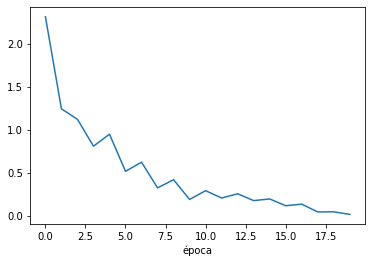

In [155]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [157]:
evaluation(model=model, loader=test_dataloader)

Accuracy: 0.7691


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)